In [1]:
# Importing Important Libraries
import warnings 
warnings.filterwarnings("ignore") 

import re   
import nltk  
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import * 
from wordcloud import WordCloud 

import numpy as np 
import pandas as pd
pd.set_option("display.max_colwidth", 5000) 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
# read data
df = pd.read_csv("train_2kmZucJ.csv")

# Data Inspection

In [3]:
df.head(2)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/


In [4]:
print(df.shape)
print(df['label'].value_counts())
# 0 positive 5894
# 1 Negative 2026

(7920, 3)
0    5894
1    2026
Name: label, dtype: int64


In [5]:
df[df['label'] == 1].head(2)

,id,label,tweet
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!
5,6,1,iPhone software update fucked up my phone big time Stupid iPhones


In [6]:
df[df['label'] == 0].head(2)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/


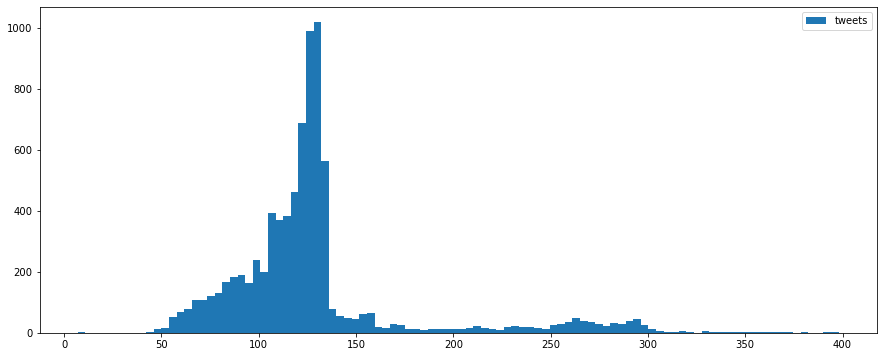

In [7]:
#we will check the distribution of length of the tweets, 
#in terms of words, in both train and test data
length = df['tweet'].str.len()
plt.figure(figsize=(15,6))
plt.hist(length, bins=100, label="tweets")  
plt.legend() 
plt.show()

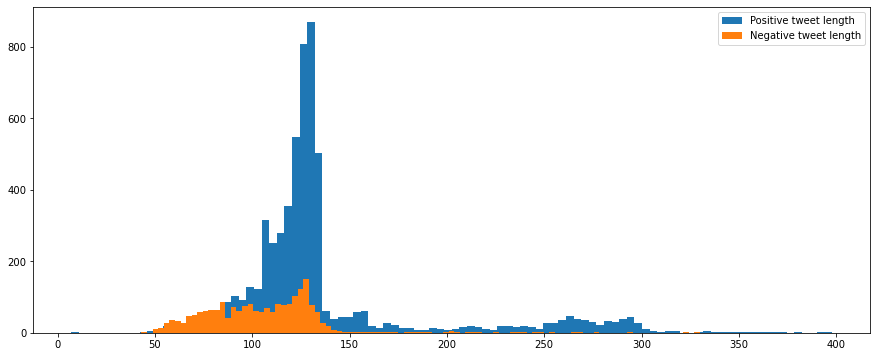

In [8]:
plt.figure(figsize=(15,6))
plt.hist(df[df['label'] == 0]['tweet'].str.len(),bins = 100, label="Positive tweet length")
plt.hist(df[df['label'] == 1]['tweet'].str.len(),bins = 100, label="Negative tweet length")
plt.legend() 
plt.show()

# Data Cleaning


<h3> 1. Train Test Split </h3>

In [9]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df["tweet"], df['label'],                                                            
                                                          random_state=42,
                                                          test_size=0.3)
xtrain = pd.DataFrame(xtrain,columns=["tweet"]).reset_index(drop=True)
ytrain = pd.DataFrame(ytrain,columns=["label"]).reset_index(drop=True)
xvalid = pd.DataFrame(xvalid,columns=["tweet"]).reset_index(drop=True)
yvalid = pd.DataFrame(yvalid,columns=["label"]).reset_index(drop=True)
print(xtrain.shape,xvalid.shape)

(5544, 1) (2376, 1)


In [10]:
xtrain[:2]

,tweet
0,Love my apple watch #apple #watch #42mm #excited #christmas #came #early #instagood… https://instagram.com/p/-R5GADCn7n/
1,My girl(: #demi #lavato #lavatic #cute #sexy #fine #music #singing #iphone http://instagr.am/p/NVUE8yzOI-/


<h3> 2. Removing Patterns </h3>

Defining a function to remove unwanted text from tweets

findall returns a list of all non-overlapping matches in the string.
re.sub = Return the string obtained by replacing the leftmost
non-overlapping occurrences of the pattern in string by the
replacement repl.

t1 = test['tweet'][1]
-->
'currently wearing my  pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/'

r = re.findall("#[\w]*",t1)
-->
['#apple', '#iMac', '#cashmoney', '#raddest', '#swagswagswag']

t1 = re.sub(r[0],'', t1)
-->
'currently wearing my  pants.  #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/'

In [11]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt) 
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

In [12]:
#1 Removing the @user identifiers ## train set
xtrain['mod_tweet'] = np.vectorize(remove_pattern)(xtrain['tweet'], "@[\w]*")
## valid set
xvalid['mod_tweet'] = np.vectorize(remove_pattern)(xvalid['tweet'], "@[\w]*")
xtrain.head(2)

,tweet,mod_tweet
0,Love my apple watch #apple #watch #42mm #excited #christmas #came #early #instagood… https://instagram.com/p/-R5GADCn7n/,Love my apple watch #apple #watch #42mm #excited #christmas #came #early #instagood… https://instagram.com/p/-R5GADCn7n/
1,My girl(: #demi #lavato #lavatic #cute #sexy #fine #music #singing #iphone http://instagr.am/p/NVUE8yzOI-/,My girl(: #demi #lavato #lavatic #cute #sexy #fine #music #singing #iphone http://instagr.am/p/NVUE8yzOI-/


<h3> 3. Removing Punctuations, Numbers, stopwords and Special Characters </h3>

Here we will replace everything except characters and hashtags with spaces. 

The regular expression “[^a-zA-Z#]” means anything except alphabets and ‘#’.

In [13]:
# string.punctuation
puncs = '"!!$%&\'(:)*+,-;<=>?^^`{|}~'

In [14]:
xtrain['mod_tweet'] = xtrain['mod_tweet'].str.replace("[^a-zA-Z#]", " ") 
xvalid['mod_tweet'] = xvalid['mod_tweet'].str.replace("[^a-zA-Z#]", " ") 

xtrain['mod_tweet']=xtrain['mod_tweet'].apply(lambda x: ' '.join([w for w in x.split() if w not in puncs]))
xvalid['mod_tweet']=xvalid['mod_tweet'].apply(lambda x: ' '.join([w for w in x.split() if w not in puncs]))

xtrain.head(2)

,tweet,mod_tweet
0,Love my apple watch #apple #watch #42mm #excited #christmas #came #early #instagood… https://instagram.com/p/-R5GADCn7n/,Love my apple watch #apple #watch # mm #excited #christmas #came #early #instagood https instagram com p R GADCn n
1,My girl(: #demi #lavato #lavatic #cute #sexy #fine #music #singing #iphone http://instagr.am/p/NVUE8yzOI-/,My girl #demi #lavato #lavatic #cute #sexy #fine #music #singing #iphone http instagr am p NVUE yzOI


In [15]:
# nltk.download('stopwords')

In [16]:
stp_wrds = stopwords.words('english')
stp_wrds = stp_wrds +["'I'm",'us','go?']

In [17]:
#3. Removing Stop Words
 
xtrain['mod_tweet']=xtrain['mod_tweet'].apply(lambda x: ' '.join([w for w in x.split() 
                                                          if w.lower() not in stp_wrds]))
xtrain['mod_tweet']=xtrain['mod_tweet'].apply(lambda x: ' '.join([w for w in x.split() 
                                                                  if len(w)>2]))

xvalid['mod_tweet']=xvalid['mod_tweet'].apply(lambda x: ' '.join([w for w in x.split() 
                                                          if w.lower() not in stp_wrds]))
xvalid['mod_tweet']=xvalid['mod_tweet'].apply(lambda x: ' '.join([w for w in x.split() 
                                                                  if len(w)>2]))


xtrain.head(2)

,tweet,mod_tweet
0,Love my apple watch #apple #watch #42mm #excited #christmas #came #early #instagood… https://instagram.com/p/-R5GADCn7n/,Love apple watch #apple #watch #excited #christmas #came #early #instagood https instagram com GADCn
1,My girl(: #demi #lavato #lavatic #cute #sexy #fine #music #singing #iphone http://instagr.am/p/NVUE8yzOI-/,girl #demi #lavato #lavatic #cute #sexy #fine #music #singing #iphone http instagr NVUE yzOI


<h3> Tokenization & Text Normalization (Stemming or Lemmatization) </h3>
tokenization is the process of splitting a string of text into tokens/words.

Stemming and Lemmatization brings the word to its root form.

Stem word (may not be a true word),
Lemmatized word would be a true word.

In [18]:
stemmer = PorterStemmer() 
lemmatizer = WordNetLemmatizer()
def tokenize_and_normalize(df):
    tokenized_tweet = df['mod_tweet'].apply(lambda x: x.split())
    # tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
    tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i.lower()) for i in x])
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) 
    
    df['mod_tweet'] = tokenized_tweet
    
    return df


In [19]:
xtrain = tokenize_and_normalize(xtrain)
xvalid = tokenize_and_normalize(xvalid)
print(xtrain.shape, xvalid.shape)
xtrain.head(2)


(5544, 2) (2376, 2)


,tweet,mod_tweet
0,Love my apple watch #apple #watch #42mm #excited #christmas #came #early #instagood… https://instagram.com/p/-R5GADCn7n/,love apple watch #apple #watch #excited #christmas #came #early #instagood http instagram com gadcn
1,My girl(: #demi #lavato #lavatic #cute #sexy #fine #music #singing #iphone http://instagr.am/p/NVUE8yzOI-/,girl #demi #lavato #lavatic #cute #sexy #fine #music #singing #iphone http instagr nvue yzoi


# Story Generation and Data Visualization
    Exploring and visualizing data, no matter whether its text or any other data, is an essential step in gaining insights. 
    Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

    * What are the most common words in the entire dataset?
    * What are the most common words in the dataset for negative and positive tweets, respectively?
    * How many hashtags are there in a tweet?
    * Which trends are associated with my dataset?
    * Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

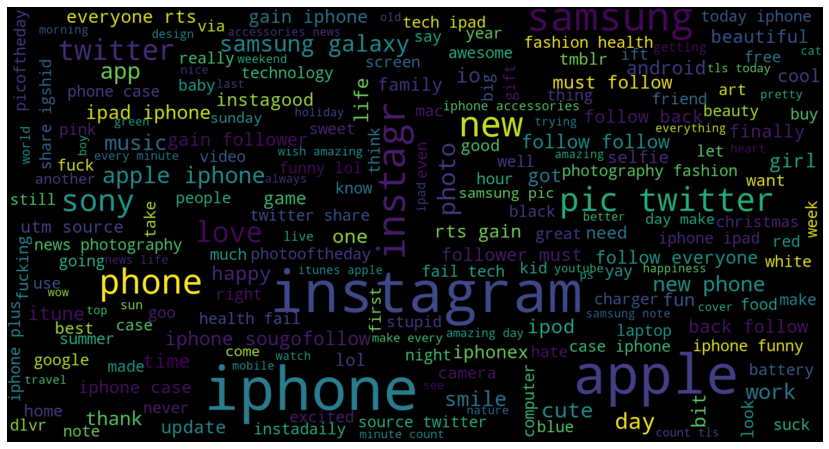

In [20]:
# Creating wordcloud for xtrain
all_words = ' '.join([txt for txt in xtrain['mod_tweet']]) #string with all the words in it (words can repeat)

wordcloud = WordCloud(width=1500, height=800, random_state=21, max_font_size=110).generate(all_words)
# wordcloud ranks words according to their frequencies and higher rank words are larger

plt.figure(figsize=(15, 8)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

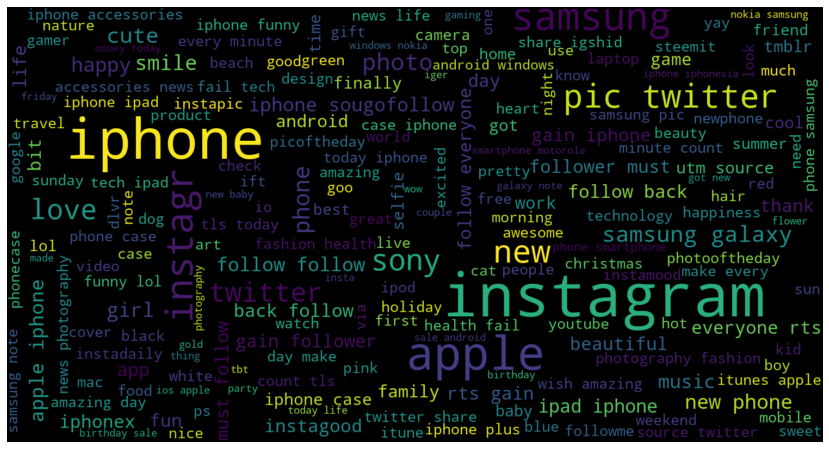

In [21]:
# Wordcloud with positive sentiments
pos_words = ' '.join([text for text in xtrain[ytrain['label']==0]['mod_tweet']]) 
wordcloud = WordCloud(width=1500, height=800, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 8)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

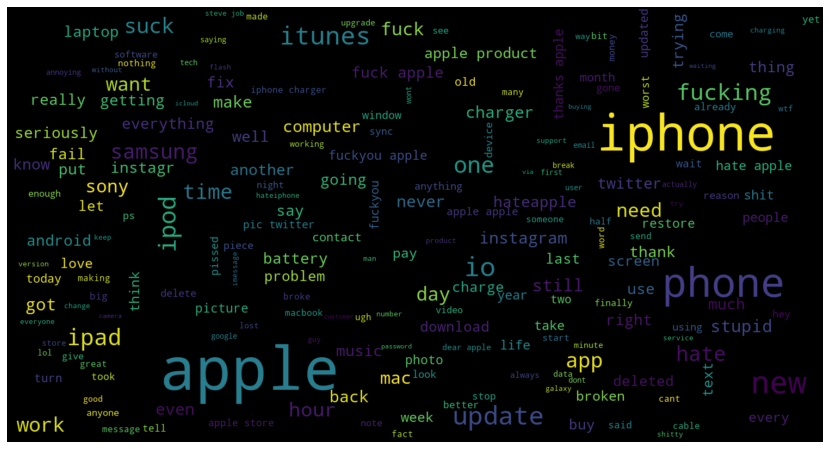

In [22]:
# Wordcloud with positive sentiments
neg_words = ' '.join([text for text in xtrain[ytrain['label']==1]['mod_tweet']]) 
wordcloud = WordCloud(width=1500, height=800, random_state=21, max_font_size=110).generate(neg_words)

plt.figure(figsize=(15, 8)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [23]:
# function to collect hashtags 
def hashtag_extract(x):
    hashtags = []    # Loop over the words in the tweet    
    for i in x:        
        ht = re.findall(r"#(\w+)", i)        
        hashtags.append(ht)     
    return hashtags

In [24]:
# extracting hashtags from positive tweets 
HT_pos = hashtag_extract(xtrain['mod_tweet'][ytrain['label'] == 0]) 
HT_pos[:2]

[['apple', 'watch', 'excited', 'christmas', 'came', 'early', 'instagood'],
 ['demi',
  'lavato',
  'lavatic',
  'cute',
  'sexy',
  'fine',
  'music',
  'singing',
  'iphone']]

In [25]:
# extracting hashtags from negative tweets 
HT_neg = hashtag_extract(xtrain['mod_tweet'][ytrain['label'] == 1]) 
HT_neg[:4]

[[], ['apple'], ['apple'], ['apple']]

In [26]:
#Unnest the lists --> add all the list to create a single list
HT_pos = sum(HT_pos,[]) 
HT_neg = sum(HT_neg,[]) 

In [27]:
nltk.FreqDist(HT_pos)

FreqDist({'iphone': 2240, 'apple': 968, 'samsung': 849, 'sony': 526, 'ipad': 239, 'android': 234, 'life': 225, 'me': 213, 'cute': 202, 'photography': 199, ...})

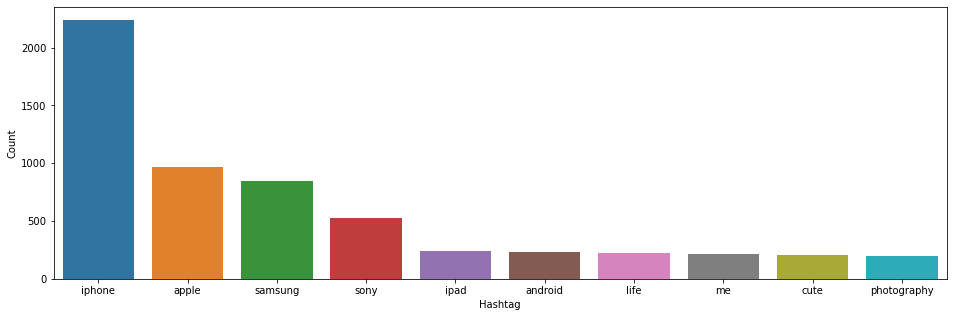

In [28]:
# Positive Tweets
a = nltk.FreqDist(HT_pos) 
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())}) 
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "Hashtag", y = "Count", orient= "v") 

# All these hashtags are positive and it makes sense. 

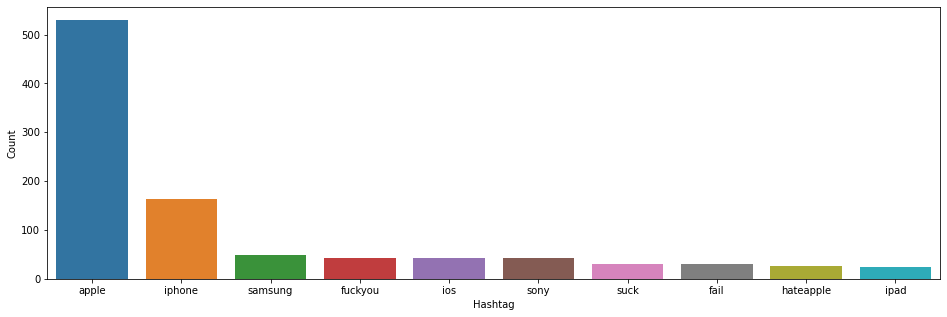

In [29]:
# Negative Tweets
a = nltk.FreqDist(HT_neg) 
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())}) 
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "Hashtag", y = "Count", orient= "v") 

# All these hashtags are positive and it makes sense. 

In [30]:
print("Total number of words: ",len(all_words), "\n \t unique words: ",len(set(all_words.split(" "))))

Total number of words:  560343 
 	 unique words:  18076


In [31]:
xtrain.drop("tweet",axis=1, inplace =True)
xvalid.drop("tweet",axis=1, inplace =True)
print(xtrain.shape,xvalid.shape)

(5544, 1) (2376, 1)


<h1> Create BOW / TFIDF / Word2Vec </h1>

In [32]:
#1. Bag of words:
bow_vectorizer = CountVectorizer(max_df=0.90,ngram_range=(1,2)) 
bow_train = bow_vectorizer.fit_transform(xtrain["mod_tweet"]) 
bow_valid = bow_vectorizer.transform(xvalid["mod_tweet"])
print(bow_train.shape,bow_valid.shape)


(5544, 62775) (2376, 62775)


In [33]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, ngram_range=(1,2)) 
tfidf_train = tfidf_vectorizer.fit_transform(xtrain['mod_tweet']) 
tfidf_valid = tfidf_vectorizer.transform(xvalid['mod_tweet']) 
print(tfidf_train.shape,tfidf_valid.shape)

(5544, 62775) (2376, 62775)


In [34]:
%%time
# Let’s train a Word2Vec model on our corpus.

train_tokenized_tweet = xtrain['mod_tweet'].apply(lambda x: x.split())
emb_size = 500
print(len(train_tokenized_tweet))
model_w2v = gensim.models.Word2Vec(
            train_tokenized_tweet,
            vector_size=emb_size, # word embedding size
            window=5, # context window size
            min_count=1,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 1, # for negative sampling
            workers= -1, # no.of cores
            seed = 0) 

model_w2v.train(train_tokenized_tweet, total_examples= len(train_tokenized_tweet), epochs=10)
print(model_w2v.wv.vectors.shape)

5544
(18075, 500)
CPU times: user 509 ms, sys: 29.5 ms, total: 538 ms
Wall time: 553 ms


In [35]:
model_w2v.wv.most_similar('girl', topn=3)

[('whyyyyyyyy', 0.1752568781375885),
 ('#lumialove', 0.16925877332687378),
 ('zn', 0.16604487597942352)]

In [36]:
print(len(model_w2v.wv.get_vector("girl")))
print(model_w2v.wv.get_vector("girl")[1:10])

500
[ 3.0483771e-04 -4.1155625e-04  7.7514217e-04  7.7750301e-04
 -1.3796821e-03  1.0927658e-03  1.3874102e-04  8.4154126e-05
 -4.3013619e-04]


In [37]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            # summing up all the words vectors in a tweet
            vec += model_w2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError:
            # handling the case where the token is not in vocabulary
            continue
#     if count != 0:
#         # Normalizing
#         vec /= count
    return vec

In [38]:
# Preparing word2vec feature set…
def prepare_w2v_doc(x_df,emb_size):
    tokenized_tweet = x_df['mod_tweet'].apply(lambda x: x.split())
    w2v_array = np.zeros((len(x_df), emb_size)) 
    for i in range(len(x_df)):
        w2v_array[i,:] = word_vector(tokenized_tweet[i], emb_size)
    
    w2v_df = pd.DataFrame(w2v_array)
    
    return w2v_df
    
train_w2v_df = prepare_w2v_doc(xtrain,emb_size)
valid_w2v_df = prepare_w2v_doc(xvalid,emb_size)

print(train_w2v_df.shape, valid_w2v_df.shape)

(5544, 500) (2376, 500)


# Modeling:

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

Logistic Regression

Support Vector Machine

RandomForest

XGBoost

#### Logistic Regression Model

In [39]:
#Bag-of-Words Features
lreg = LogisticRegression() 
# training the model 
lreg.fit(bow_train, ytrain)
prediction = lreg.predict_proba(bow_valid) 
# predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set
# score: 0.8074179743223967

0.8074179743223967

In [40]:
#TF-IDF Features
# We’ll follow the same steps as above, but now for the TF-IDF feature set.
lreg = LogisticRegression() 

lreg.fit(tfidf_train, ytrain) 
prediction = lreg.predict_proba(tfidf_valid) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid["label"], prediction_int) 
# calculating f1 score for the validation set
# score: 0.8109627547434997

0.8109627547434997

In [41]:
#Word2Vec Features
lreg = LogisticRegression() 

lreg.fit(train_w2v_df, ytrain) 
prediction = lreg.predict_proba(valid_w2v_df) 
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)
# score: 0.7712418300653594


0.7831149927219796

#### Support Vector Machine (SVM)

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. 

In [42]:
# Bag-of-Words Features
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc.fit(bow_train, ytrain) 
prediction = svc.predict_proba(bow_valid) 
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)
# without n-gramns: 0.8008534850640114

0.7997159090909092

In [43]:
#TF-IDF Features
svc = svm.SVC(kernel='linear', 
C=1, probability=True).fit(tfidf_train, ytrain) 
prediction = svc.predict_proba(tfidf_valid) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)
# score : 0.8171886380189367

0.8177842565597667

In [44]:
#Word2Vec Features

svc = svm.SVC(kernel='linear', C=1, probability=True).fit(train_w2v_df, ytrain) 
prediction = svc.predict_proba(valid_w2v_df) 
prediction_int = prediction[:,1] >= 0.25
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)
#0.7690288713910761

0.7726971504307488

# RandomForest

Random Forest is a versatile machine learning algorithm capable of performing both regression and classification tasks. It is a kind of ensemble learning method, where a few weak models combine to form a powerful model.

In [45]:
# Bag-of-Words Features
rfc= RandomForestClassifier(n_estimators= 400, random_state = 101)
rfc.fit(bow_train, ytrain)
prediction = rfc.predict(bow_valid)

f1_score(yvalid, prediction)
# score: 0.7777777777777777


0.782608695652174

In [46]:
#TF-IDF Features

rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(tfidf_train, ytrain) 
prediction = rf.predict(tfidf_valid) 

f1_score(yvalid, prediction)
# score: 0.7816627816627817


0.7836166924265843

In [47]:
# Word2Vec Features

rfc = RandomForestClassifier(n_estimators=400, random_state=11).fit(train_w2v_df, ytrain) 
prediction = rfc.predict(valid_w2v_df) 
f1_score(yvalid, prediction)
#score: 0.6399270738377394

0.658865886588659

# XGBoost

Extreme Gradient Boosting (xgboost) is an advanced implementation of gradient boosting algorithm. 

It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. It also has additional features for doing cross validation and finding important variables. There are many parameters which need to be controlled to optimize the model.

In [48]:
#Bag-of-Words Features

xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
xgb_model.fit(bow_train, ytrain) 
prediction = xgb_model.predict(bow_valid) 
f1_score(yvalid, prediction)

#score: 0.7682737169517884

[23:25:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7766536964980545

In [49]:
# TF-IDF Features

xgb = XGBClassifier(max_depth=6, n_estimators=1000,eval_metric = "logloss")
xgb.fit(tfidf_train, ytrain) 
prediction = xgb.predict(tfidf_valid) 
f1_score(yvalid, prediction)
#score: 0.7208427389014296

0.7250755287009063

In [51]:
# Word2Vec Features

xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3,eval_metric = "logloss")
xgb.fit(train_w2v_df, ytrain)
prediction = xgb.predict(valid_w2v_df) 
f1_score(yvalid, prediction)
# score: 0.7700701480904131

0.7581395348837211

# FineTuning XGBoost + Word2Vec
XGBoost has quite a many tuning parameters and sometimes it becomes tricky to properly tune them.

In [52]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

dtrain = xgb.DMatrix(train_w2v_df, label=ytrain) 
dvalid = xgb.DMatrix(valid_w2v_df, label=yvalid) 

# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
 }

In [53]:
# We will prepare a custom evaluation metric to calculate F1 score.

def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

In [ ]:
# Tuning max_depth and min_child_weight
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,8)
     for min_child_weight in range(5,7)
 ]

max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

     # Cross-validation
    cv_results = xgb.cv(params,
                        dtrain,
                        feval= custom_eval,
                        num_boost_round=200,
                        maximize=True,
                        seed=16,
                        nfold=5,
                        early_stopping_rounds=10,
    )   
    
    # Finding best F1 Score
    
    mean_f1 = cv_results['test-f1_score-mean'].max()

    boost_rounds = cv_results['test-f1_score-mean'].argmax()    
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))    
    if mean_f1 > max_f1:
            max_f1 = mean_f1
            best_params = (max_depth,min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))
    

In [54]:
#Updating max_depth and min_child_weight parameters.

params['max_depth'] = 6 
params['min_child_weight'] = 7

In [ ]:
#Tuning subsample

gridsearch_params = [(subsample)
    for subsample in [i/10. for i in range(5,10)]]


max_f1 = 0. 
best_params = None 
for subsample in gridsearch_params:
    print("CV with subsample={}".format(subsample))
    # Update our parameters
    params['subsample'] = subsample
    
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )   
    
    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample) 
        
        
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))    

In [55]:
# Updating subsample 

params['subsample'] = .6

In [ ]:
# Now let’s tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    
    # Update ETA
    params['eta'] = eta
    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )
    
    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

In [56]:
params['eta'] = 0.2
params

{'objective': 'binary:logistic',
 'max_depth': 6,
 'min_child_weight': 7,
 'eta': 0.2,
 'subsample': 0.6,
 'colsample_bytree': 1}

In [58]:
xgb_model = xgb.train(
            params,
            dtrain,
            feval= custom_eval,
            num_boost_round= 120,
            maximize=True,
            evals=[(dvalid, "Validation")],
            early_stopping_rounds=20
         )

[23:28:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	Validation-logloss:0.60800	Validation-f1_score:0.00000
[1]	Validation-logloss:0.54664	Validation-f1_score:0.46285
[2]	Validation-logloss:0.49978	Validation-f1_score:0.45238
[3]	Validation-logloss:0.46406	Validation-f1_score:0.51897
[4]	Validation-logloss:0.43666	Validation-f1_score:0.54672
[5]	Validation-logloss:0.41552	Validation-f1_score:0.57088
[6]	Validation-logloss:0.39773	Validation-f1_score:0.59906
[7]	Validation-logloss:0.38460	Validation-f1_score:0.60093
[8]	Validation-logloss:0.37362	Validation-f1_score:0.62328
[9]	Validation-logloss:0.36481	Validation-f1_score:0.61805
[10]	Validation-logloss:0.35804	Validation-f1_score:0.63415
[11]	Validation-logloss:0.35362	Validation-f1_score:0.64337
[12]	Val